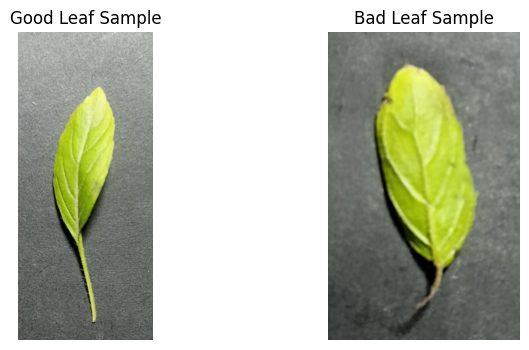

      Category  Total Count
0  Good Leaves          504
1   Bad Leaves          499


In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd

# Define dataset paths
good_folder = "dataset/Good"
bad_folder = "dataset/Bad"

# Function to load one sample image and count images
def load_sample_and_count(folder):
    images = os.listdir(folder)
    total_count = len(images)
    
    sample_img = None
    if images:
        sample_img_path = os.path.join(folder, images[0])
        sample_img = cv2.imread(sample_img_path)
        if sample_img is not None:
            sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    
    return total_count, sample_img

# Get counts and sample images
good_count, good_sample = load_sample_and_count(good_folder)
bad_count, bad_sample = load_sample_and_count(bad_folder)

# Display sample images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(good_sample)
plt.axis("off")
plt.title("Good Leaf Sample")

plt.subplot(1, 2, 2)
plt.imshow(bad_sample)
plt.axis("off")
plt.title("Bad Leaf Sample")
plt.show()

# Show count
df = pd.DataFrame({
    "Category": ["Good Leaves", "Bad Leaves"],
    "Total Count": [good_count, bad_count]
})
print(df)

In [3]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def extract_features(image):
    # Resize to fixed size
    image = cv2.resize(image, (128, 128))
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # ---- Color features ----
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_hsv = cv2.mean(hsv)[:3]  # Hue, Saturation, Value mean
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # ---- Shape features ----
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = 0
    perimeter = 0
    aspect_ratio = 0
    solidity = 0
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        x, y, w, h = cv2.boundingRect(largest_contour)
        aspect_ratio = float(w) / h
        solidity = area / cv2.contourArea(cv2.convexHull(largest_contour))

    # ---- Texture features ----
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]

    # ---- Feature vector ----
    features = list(mean_hsv) + hist.tolist() + [area, perimeter, aspect_ratio, solidity, contrast, correlation, energy]
    return features

In [6]:
def extract_dataset_features(folder_path, label):
    features = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        image = cv2.imread(file_path)
        if image is not None:
            feats = extract_features(image)
            features.append(feats)
            labels.append(label)
    return features, labels

# Extract features for both classes
good_features, good_labels = extract_dataset_features(good_folder, 1)
bad_features, bad_labels = extract_dataset_features(bad_folder, 0)

# Combine both
X = np.array(good_features + bad_features)
y = np.array(good_labels + bad_labels)

# Random Forest

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [16]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred)*100)

Accuracy: 93.53233830845771


In [20]:
labels = ["Bad Leaf", "Good Leaf"]
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

    Bad Leaf       0.91      0.96      0.94       100
   Good Leaf       0.96      0.91      0.93       101

    accuracy                           0.94       201
   macro avg       0.94      0.94      0.94       201
weighted avg       0.94      0.94      0.94       201



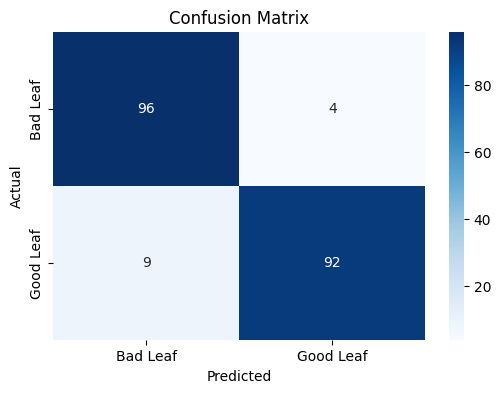

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["Bad Leaf", "Good Leaf"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

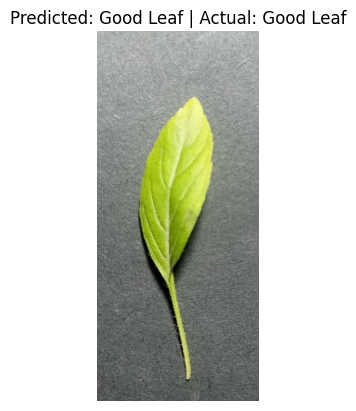

Predicted: Good Leaf
Actual: Good Leaf


In [24]:
import matplotlib.pyplot as plt

def predict_leaf(path, actual_label):
    # Load image
    image = cv2.imread(path)
    if image is None:
        print("Image not found.")
        return
    
    # Predict
    features = extract_features(image)
    prediction = model.predict([features])[0]
    predicted_label = "Good Leaf" if prediction == 1 else "Bad Leaf"

    # Convert image for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot image with prediction and actual label
    plt.imshow(image_rgb)
    plt.title(f"Predicted: {predicted_label} | Actual: {actual_label}")
    plt.axis("off")
    plt.show()
    
    # Return both values if needed
    return predicted_label

# Example usage
# Assume the actual label is known for this image
actual = "Good Leaf"
result = predict_leaf("dataset/Good/1718969775667.jpg", actual)
print("Predicted:", result)
print("Actual:", actual)

In [26]:
import os
import cv2
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

def extract_features(image):
    # Resize to fixed size
    image = cv2.resize(image, (128, 128))
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # ---- Color features ----
    mean_color = cv2.mean(image)[:3]  # BGR mean

    # ---- Shape features (Contour area and perimeter) ----
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = 0
    perimeter = 0
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)

    # ---- Texture features (GLCM contrast) ----
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]

    # ---- Feature vector ----
    features = list(mean_color) + [area, perimeter, contrast]
    return features

def create_feature_dataframe(good_folder, bad_folder):
    # Prepare lists to hold the data
    data_good = []
    data_bad = []
    
    # Process good leaves
    for file in os.listdir(good_folder):
        path = os.path.join(good_folder, file)
        image = cv2.imread(path)
        if image is not None:
            features = extract_features(image)
            data_good.append(features)
    
    # Process bad leaves
    for file in os.listdir(bad_folder):
        path = os.path.join(bad_folder, file)
        image = cv2.imread(path)
        if image is not None:
            features = extract_features(image)
            data_bad.append(features)
    
    # Column names based on the extracted features
    column_names = ['Mean B', 'Mean G', 'Mean R', 'Area', 'Perimeter', 'Contrast']
    
    # Create DataFrame for good leaves
    df_good = pd.DataFrame(data_good, columns=column_names)
    df_good['Label'] = 'Good'  # Add label column
    
    # Create DataFrame for bad leaves
    df_bad = pd.DataFrame(data_bad, columns=column_names)
    df_bad['Label'] = 'Bad'  # Add label column
    
    return df_good, df_bad

# Example usage
good_folder = "dataset/Good"  # Update with the actual path
bad_folder = "dataset/Bad"    # Update with the actual path

df_good, df_bad = create_feature_dataframe(good_folder, bad_folder)

# Save DataFrames as CSV files
df_good.to_csv('good_leaves_features.csv', index=False)  # Save good leaves DataFrame to CSV
df_bad.to_csv('bad_leaves_features.csv', index=False)    # Save bad leaves DataFrame to CSV

print("CSV files saved: 'good_leaves_features.csv' and 'bad_leaves_features.csv'")

CSV files saved: 'good_leaves_features.csv' and 'bad_leaves_features.csv'


# K-Nearest Neighbors (KNN)

In [29]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Evaluate KNN
y_pred_knn = knn_model.predict(X_test)

In [31]:
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn)*100)

KNN Accuracy: 59.20398009950249


In [33]:
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn))


KNN Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.50      0.55       100
           1       0.58      0.68      0.63       101

    accuracy                           0.59       201
   macro avg       0.59      0.59      0.59       201
weighted avg       0.59      0.59      0.59       201



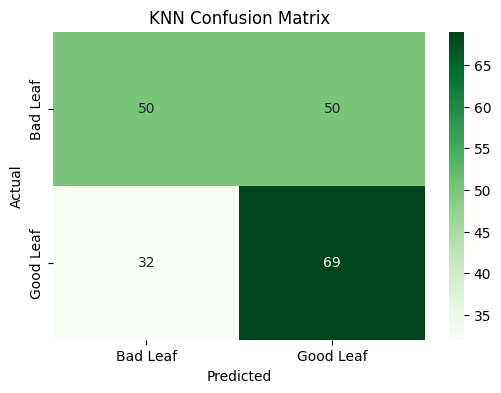

In [35]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.show()

# Support Vector Machine (SVM)

In [56]:
from sklearn.svm import SVC

# Train SVM
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test)

In [58]:
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm)*100)

SVM Accuracy: 62.189054726368155


In [60]:
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.72      0.65       100
           1       0.65      0.52      0.58       101

    accuracy                           0.62       201
   macro avg       0.63      0.62      0.62       201
weighted avg       0.63      0.62      0.62       201



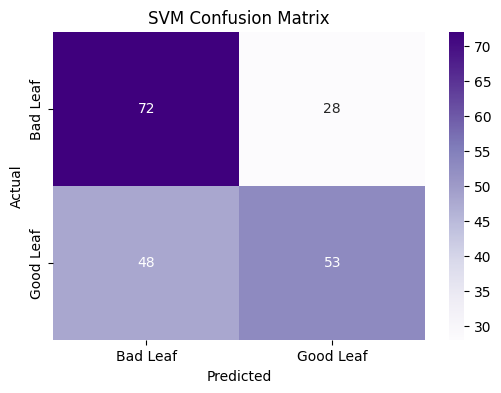

In [62]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap="Purples", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

# Naive Bayes

In [67]:
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Evaluate Naive Bayes
y_pred_nb = nb_model.predict(X_test)

In [69]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb)*100)

Naive Bayes Accuracy: 70.64676616915423


In [71]:
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71       100
           1       0.71      0.69      0.70       101

    accuracy                           0.71       201
   macro avg       0.71      0.71      0.71       201
weighted avg       0.71      0.71      0.71       201



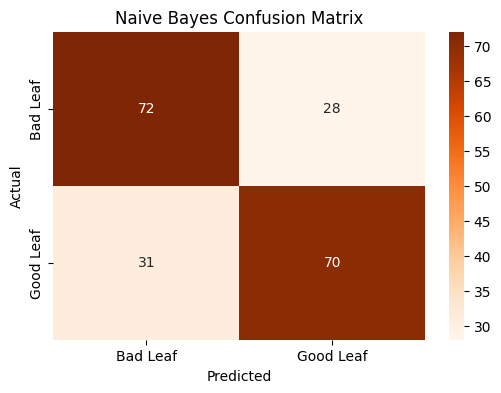

In [75]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap="Oranges", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

In [81]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate Decision Tree
y_pred_dt = dt_model.predict(X_test)

In [83]:
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt)*100)

Decision Tree Accuracy: 91.54228855721394


In [85]:
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       100
           1       0.93      0.90      0.91       101

    accuracy                           0.92       201
   macro avg       0.92      0.92      0.92       201
weighted avg       0.92      0.92      0.92       201



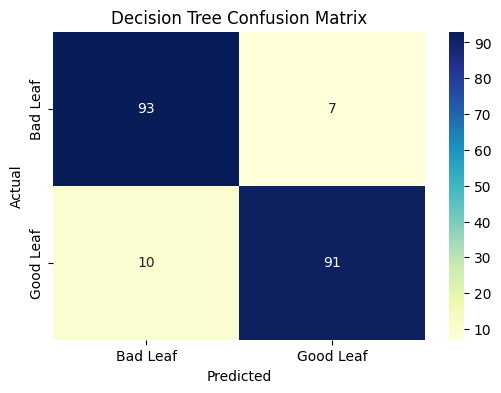

In [87]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()


# Logistic Regression

In [94]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_test)

C:\Users\anant\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr)*100)

Logistic Regression Accuracy: 72.636815920398


In [98]:
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.81      0.75       100
           1       0.77      0.64      0.70       101

    accuracy                           0.73       201
   macro avg       0.73      0.73      0.72       201
weighted avg       0.73      0.73      0.72       201



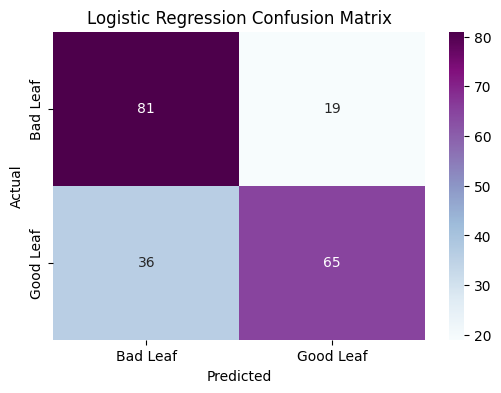

In [118]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap="BuPu", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()